# Counterfactual transformer for macroeconomic policy simulation

The core idea is to use **counterfactual shifts** to simulate macroeconomic scenarios based on changes in one key indicator variable $i$ - the conditioning variable $c$. That is to say, to determine the effectiveness of for example a central bank policy measured by $\textbf{x} = {x_1, x_2, ..., x_m}, \textbf{x} \subset X \land i \in X$ (with $\textbf{x} = X \setminus y$) when the exchange rate of a certain currency $i$ would have been different from that found in the real data (counterfactually shifting observed $i$ to simulated $c$ under macroeconomic scenario $s$), one needs to be able to model the effect of changes in variable $i$ on all other variables $\textbf{x}$ in the dataset $X$.

### The Bayesian model

To formalize, the generative model needs to learn both the joint probability

$$ P(i_t,\textbf{x}_t) = P(X_{t-n:t-1}|i_{t-n:t-1},\textbf{x}_{t-n:t-1}), i \in X, \textbf{x} \subset X, i \notin \textbf{x}$$

of the conditioning variable $i$ and the conditioned variables $\textbf{x} \subset X$ at time $t$ conditional on previous timesteps ${t-n, ..., t-1}$, **and** the conditional probability of $\textbf{x}$ given $i$ at time $t$ conditioned on a macroeconomic scenario $s$, where $i_t^s = c_t$,

$$P(\textbf{x}_t|c_t)$$

From a Bayesian point of view, it makes sense to take the distribution in the real data as the prior. This means that the model needs to
1. Approximate the $n$ historical autoregressive priors for all variables $p(X_t|X_{t-n:t-1})$ at $X_t$ given $X_{t-n}, ..., X_{t-1}$.
2. Infer the posterior distribution $p(X_{t-n:t-1},\beta,\gamma|X_t) \propto p(X_t|X_{t-n:t-1},\beta,\gamma)p(X_t|X_{t-n:t-1})$, where $\gamma$ maps contemporary relationships between variables at time $t$ and $\beta$ models the autoregressive relationship over time for all variables, mapping $X_{t-n:t-1}$ on to $X_t$.
3. Use the inferred posterior of the variables $\textbf{x}$ to generate $Y = c,P(\textbf{x}|c,s,\beta,\gamma)$, where $c$ is the conditioned form of $i$ shifted to simulate some explicitly programmed counterfactual scenario $s$, and $P(\textbf{x}|c,s)$ are the values of $\textbf{x}$ mapped onto this counterfactual scenario $s$. 

Given that a scenario $s$ can also be modeled as a regime, it might be good to look into RL research on the topic of policy switches in model-based RL.

### Counterfactuals

From a causal inference standpoint, policy simulations should result in an estimate of either individual treatment effects ($ITE_i = Y_1^{(i)} - Y_0^{(i)}$ for treatment (1) and non-treatment (0) conditions on unit $i$), or average treatment effects ($ATE = 1/N \sum\limits_i y_1(i) - y_0(i)$) of the policy intervention $c$ on the other variables $\textbf{x}$.

In the language of causal analysis, the factual variable $i$ and counterfactual variable $c$ under scenario $s$ are investigated. Therefore the generator should learn to model not only the generated variables but also underlying confounders, which are hypothesized to aid in generating more realistic simulations.

### Training and inference

The model is trained as a conditional timeseries transformer, generating datapoints conditional both on $\textbf{A}$) autoregressive previous timesteps ${t-n, ..., t-1}$ and $\textbf{B}$) lateral relationships between variables (longitudinal and contemporary effects), ignoring $\textbf{C}$) the conditional variable $c$ during training. During inference $c$ is shifted to simulate the counterfactual condition $\textbf{C}$), letting the generator model the effect of $c$ on the $x \subset X$ variables of interest.

The training data will come from a training pool consisting of datapoints for some 100 or so countries, shuffled for training purposes but with country encodings to allow the model to learn different distributions. The validation data consists of a separate pool of 15 heterogeneous countries.

The model learns to predict variables $\textbf{i}_t = \textbf{x}_t$ at time $t$ given $\textbf{x}_{t-1}$ within the context of $\textbf{x}_{t-n:t-1}$. For practical purposes the data feed consists of multivariate sequences of length $n-1$, and multivariate labels with length $1$. During inference, the model needs to have access to predictions at it made at previous timesteps in order to set the generated context $\hat{\textbf{x}}_{t-n:t-1}$.

###### Reconstruction loss

The correctness of the generator can be measured by proxy by looking at **reconstruction losses** from historical data. I.e., provide it with a prompt of $m$ sequences on unseen historical country data, and determine how close it matched the real data for the remaining $n-m$ observations. Given the natural differences in country data, it might be good to take a pool of representative countries as the validation dataset. This will also help mitigate covariate shift issues (c.f. [Johansson et al. 2018](https://arxiv.org/abs/1605.03661)).

###### Counterfactual loss

Since we are dealing with counterfactuals, the loss metric cannot be measured directly from labeled data. However, a proxy of **counterfactual loss** could be to measure the proportional, variable-bound divergence of the simulated data from the real distribution, for example through Kullback-Leibler divergence, Fisher information, or optimal transport. The assumption underlying such an approach would be that of *real-world constraints* on macroeconomic data, i.e. the overall quantities of the indicator variable won't change as a result of counterfactual evidence, but their underlying distribution might.

A correct measurement of the loss will need to incorporate covariate shifts across country datasets into the function. One widely-used metric to include a measure thereof in the loss function is maximum-mean discrepancy (MMD, c.f. [Gretton et al., 2012](http://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf), [Sutherland et al., 2107](https://arxiv.org/abs/1611.04488)), which can be estimated empirically over the means of the real and simulated data distributions. 

In [2]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [4]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [5]:
tf.__version__

'2.2.0'

#### Load and prepare the data

In [68]:
country = 'Switzerland'

In [69]:
train_countries =['Singapore', 'Switzerland', 'Netherlands', 'Japan', 'France', 'United States', 'China',
                  'India', 'Brazil', 'Colombia', 'Indonesia', 'Senegal', 'Ghana']

In [70]:
train_countries.remove(country)

In [ ]:
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [22]:
holdout_df = pd.read_csv('features/m_one/%s_features.csv' % country, sep=';', header=0)

In [23]:
country_df = pd.concat([holdout_df, labels_df.drop(columns=['date'])], axis=1)

In [24]:
country_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.7167,0.0000,0.0000,0.0000,0.0000,71.3134,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.7171,0.0000,0.0000,0.0000,0.0000,71.3410,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.7176,0.0000,0.0000,0.0000,0.0000,71.3687,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.7180,0.0000,0.0000,0.0000,0.0000,71.3963,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.7185,0.0000,0.0000,0.0000,0.0000,71.4239,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


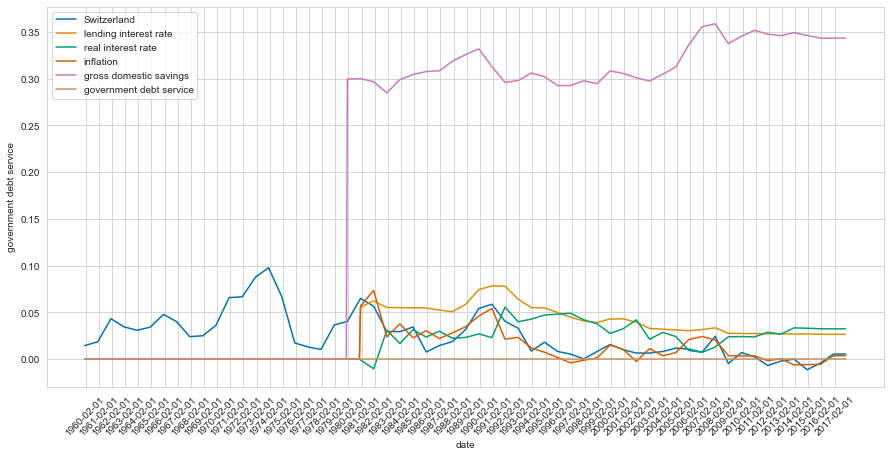

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=country_df) for c in list([country, 'lending interest rate', 'real interest rate', 'inflation', 'gross domestic savings', 'government debt service'])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(country_df['date'], rotation=45);

In [26]:
country_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'urban population', 'Brazil', 'China', 'Colombia', 'France', 'Ghana',
       'India', 'Indonesia', 'Japan', 'Netherlands', 'Seneg

In [77]:
cols = ['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
        'energy imports', 'food exports', 'high-tech exports', 'inflation',
        'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
        'broad money', 'exports of goods and services', 'gross domestic savings',
        'high-tech value added', 'household consumption expenditure',
        'imports of goods and services', 'listed companies', 'manufacturing value added',
        'r and d spend', 'services trade', 'trade', 'government debt service',
        'government interest payments external debt', 'government tax revenue', 'birth deaths',
        'broadband subscriptions', 'electricity access', 'co2 emissions',
        'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
        'rural population', 'urban population']

In [78]:
base_feature_df = country_df[cols + [country]]

In [79]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);
base_df.set_index('date');

The following feature groups are used in the simulation:

* **finance**: bank nonperforming loans, lending interest rate
* **consumption behaviour**: gross domestic savings, household consumption expenditure, <... missing: detailed consumption expenditure areas>
* **trade**: exports of goods and services, imports of goods and services, services trade, trade
* **governance**: broad money, government interest payments external debt, government tax revenue

In [80]:
model_cols = ['bank nonperforming loans', 'lending interest rate', 'gross domestic savings',
              'household consumption expenditure', 'exports of goods and services',
              'imports of goods and services', 'services trade', 'trade', 'broad money',
              'government tax revenue', 'label']

In [81]:
factual_df = base_df[model_cols]
factual_df.shape

(696, 11)

In [82]:
num_variables = len(factual_df.columns)

## Counterfactual timeseries transformer

* The model consists of a transformer architecture adapted for generating continous timeseries across $n$ variables.
* An additional conditional time series can be fed to the model to investigate the effect of counterfactual scenarios on the $n$ variables.

This setup gives macroeconomic researchers an alternative tool to investigate the robustness of policy decisions and outcomes.

In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
params = {
   'num_epochs': 25,
   'save_interval': 5,
   'num_timesteps': 4,
   'num_variables': num_variables,
   'batch_size': 16,
   'num_layers': 2,
   'd_model': 256,
   'dff': 1024,
   'num_heads': 4,
   'dropout_rate': 0.1,
   'lr': 0.1
}

In [85]:
def timeseries_dataprep(num_obs, num_variables, num_timesteps, simulation_df):
    t_at_n = []
    n_to_t = []
    t_at_n_plus_one = []
    n_plus_one_to_t_plus_one = []
    labels = []
    
    for i in range(int(num_obs)):
        n_to_t.append(simulation_df[i:(i+num_timesteps)].values)
        t_at_n.append(simulation_df[(i+num_timesteps):(i+num_timesteps+1)].values)
        t_at_n_plus_one.append(simulation_df[(i+num_timesteps+1):(i+num_timesteps+2)].values)
        n_plus_one_to_t_plus_one.append(simulation_df[i+1:(i+num_timesteps+1)].values)
        labels.append(simulation_df['label'][(i+num_timesteps+1):(i+num_timesteps+2)].values)
        
    
    n = num_obs - (num_timesteps + 1)
    
    src_input = np.asarray(t_at_n[0:n])
    src = src_input.reshape((n, num_variables, 1))
    tar_input = np.asarray(t_at_n_plus_one[0:n])
    tar = tar_input.reshape((n, num_variables, 1))
    src_history_input = np.asarray(n_to_t[0:n])
    src_history = src_history_input.reshape((n, num_variables, num_timesteps))
    y_input = np.asarray(labels[0:n])
    y = y_input.reshape((n, 1))
    
    return src, tar, src_history, y

In [152]:
def train_dataprep(cols, model_cols, num_variables, num_timesteps, countries):
    srcs = []
    tgts = []
    hist = []
    lbls = [] 

    for train_country in countries:
        # Prepare the country dataframe with time-shift labels
        country_features_df = pd.read_csv('features/m_one/%s_features.csv' % train_country, sep=';', header=0)
        train_country_df = pd.concat([country_features_df, 
                                      labels_df.drop(columns=['date'])], axis=1)[cols+[train_country]]
        train_country_df['label'] = train_country_df[train_country].shift(periods=1)
        base_train_df = train_country_df.drop(train_country, axis=1).fillna(0.00);
        base_train_df.set_index('date');
        train_df = base_train_df[model_cols]
        
        # Prepare the data for the time series transformer
        s, t, h, y = timeseries_dataprep(len(train_df), num_variables, params['num_timesteps'], train_df)
        
        srcs.append(s)
        tgts.append(t)
        hist.append(h)
        lbls.append(y)
        
    n_obs = len(countries) * len(lbls[0])
    
    srcs_input = np.asarray(srcs)
    srcs_arr = srcs_input.reshape((n_obs, num_variables, 1))
    tars_input = np.asarray(tgts)
    tar_arr = tars_input.reshape((n_obs, num_variables, 1))
    srcs_hist_input = np.asarray(hist)
    src_hist_arr = srcs_hist_input.reshape((n_obs, num_variables, num_timesteps))
    lbls_input = np.asarray(lbls)
    y_arr = lbls_input.reshape((n_obs, 1))
    
    return srcs_arr, src_hist_arr, tar_arr, y_arr

In [157]:
train_src, train_src_history, train_tar, train_y = train_dataprep(cols, model_cols, num_variables,
                                                                  params['num_timesteps'], train_countries)

In [205]:
src, tar, src_history, y = timeseries_dataprep(len(factual_df), num_variables, params['num_timesteps'], factual_df)

In [159]:
n = len(factual_df) - (params['num_timesteps'] + 1)

### Model architecture

The model architecture is that of a transformer-based time series generator. A set of variables at fixed positions is used as source, and that same set of in the next timestep is used as target. Since the model is ran over continuous variables, rather than an embedding $n$ context timesteps are fed to the model encoded with relative positional embeddings. Since the autoregression of interest are learnt from the context timesteps rather than from the position of the variable in $\textbf{x}$ (where ordering is fixed but random), some modifications had to be made to ensure the model learnt correct dependencies between variables in the multivariate set $\textbf{x}$. Furthermore, rather than tokens, the generator needs to learn continous variables. The approach here is inspired by an application of the transformer architecture to music generation by [the Google Magenta team](https://magenta.tensorflow.org/music-transformer).

The Transformer implementation in TensorFlow Keras is adapted for timeseries from [the TensorFlow transformer tutorial](https://www.tensorflow.org/beta/tutorials/text/transformer) for neural machine translation.

In [163]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [164]:
def positional_encoding(num_positions, d_model):
    angle_rads = get_angles(np.arange(num_positions)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [165]:
def scaled_dot_product_attention(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [166]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
          
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
      
    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]
      
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
      
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size) 

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    
        output = self.dense(concat_attention)
        return output, attention_weights

In [167]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), tf.keras.layers.Dense(d_model)])

In [168]:
class TimeseriesEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1):
        super(TimeseriesEncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
      
    def call(self, inputs, x, training):
        attn_output, _ = self.mha(x, k=x, q=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [169]:
sample_encoder = TimeseriesEncoderLayer(512, 8, 2048, params['num_variables'], params['num_timesteps'])
sample_encoder_output = sample_encoder(
    tf.random.uniform((params['batch_size'], params['num_variables'], 1)),
    x=tf.random.uniform((params['batch_size'], params['num_variables'], params['num_timesteps'])),
    training=False)
sample_encoder_output.shape

TensorShape([16, 11, 512])

In [170]:
class TimeseriesDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1):
        super(TimeseriesDecoderLayer, self).__init__()
    
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
    
        self.ffn = point_wise_feed_forward_network(d_model, dff)
     
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
      
      
    def call(self, inputs, x, training):
        attn1, attn_weights_block1 = self.mha1(x, k=x, q=inputs)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + inputs)
        
        attn2, attn_weights_block2 = self.mha2(x, k=x, q=out1)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [171]:
sample_decoder = TimeseriesDecoderLayer(512, 8, 2048, params['num_variables'], params['num_timesteps'])

sample_decoder_output, _, _ = sample_decoder(
    tf.random.uniform((params['batch_size'], params['num_variables'], 1)),
    x=tf.random.uniform((params['batch_size'], params['num_variables'], params['num_timesteps'])),
    training=False)

sample_decoder_output.shape

TensorShape([16, 11, 512])

In [172]:
class TimeseriesEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1):
        super(TimeseriesEncoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_variables = num_variables
        self.num_timesteps = num_timesteps
        
        self.pos_encoding = positional_encoding(self.d_model * 4, self.d_model)        
        self.enc_layers = [TimeseriesEncoderLayer(d_model, num_heads, dff,
                                                  num_variables, num_timesteps, rate) for _ in range(num_layers)]
      
        self.dropout = tf.keras.layers.Dropout(rate)
            
    def call(self, inputs, history, training):
        x = tf.concat([inputs, history], axis=-1)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :self.num_variables, :self.num_timesteps+1]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](inputs, x=x, training=training)
        
        return x

In [173]:
sample_encoder = TimeseriesEncoder(num_layers=2, d_model=params['d_model'], num_heads=params['num_heads'],
                                   dff=params['dff'], num_variables=params['num_variables'], 
                                   num_timesteps=params['num_timesteps'])

sample_encoder_output = sample_encoder(
    tf.random.uniform((params['batch_size'], params['num_variables'], 1)),
    history=tf.random.uniform((params['batch_size'], params['num_variables'], 
                               params['num_timesteps'])),
    training=False)
print (sample_encoder_output.shape)

(16, 11, 256)


In [174]:
# print (sample_encoder_output)

In [175]:
class TimeseriesDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1):
        super(TimeseriesDecoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_variables = num_variables
        self.num_timesteps = num_timesteps
        
        self.pos_encoding = positional_encoding(self.d_model * 2, self.d_model)
        self.dec_layers = [TimeseriesDecoderLayer(d_model, num_heads, dff, num_variables, num_timesteps, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
      
    def call(self, inputs, x, training):
        attention_weights = {}
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :self.num_variables, :self.d_model]
        
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](inputs, x=x, training=training)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x

In [176]:
sample_decoder = TimeseriesDecoder(num_layers=2, d_model=256, num_heads=8, dff=2048, 
                                   num_variables=params['num_variables'],
                                   num_timesteps=params['num_timesteps'])

output = sample_decoder(
    tf.random.uniform((params['batch_size'], params['num_variables'], 1)),
    x=sample_encoder_output, 
    training=False)

output.shape

TensorShape([16, 11, 256])

In [177]:
class TimeseriesTransformer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_variables, num_timesteps, batch_size, rate=0.1):
        super(TimeseriesTransformer, self).__init__()

        self.encoder = TimeseriesEncoder(num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate)
        self.reshape = tf.keras.layers.Reshape((num_variables, 1))
        self.decoder = TimeseriesDecoder(num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate)
        self.output_layer = tf.keras.layers.Dense(num_variables, kernel_initializer='he_uniform',
                                                  activation='sigmoid')
    
    def call(self, inputs, hist=None, tar=None, training=False):
        enc_output = self.encoder(inputs, history=hist, training=training)
        x = self.reshape(inputs)
        x = tf.keras.layers.Add()([x, enc_output])
        dec_output = self.decoder(tar, x=x, training=training)
        
        model_output = tf.keras.layers.Flatten()(dec_output)
        final_output = self.output_layer(model_output)
        return final_output

In [178]:
sample_transformer = TimeseriesTransformer(num_layers=1, d_model=512, num_heads=1, dff=2048, 
                                           num_timesteps=params['num_timesteps'],
                                           num_variables=params['num_variables'],
                                           batch_size=params['batch_size'])

t = tf.random.uniform((params['batch_size'], params['num_variables'], 1))
hist = tf.random.uniform((params['batch_size'], params['num_variables'], params['num_timesteps']))
t_plus_one = tf.random.uniform((params['batch_size'], params['num_variables'], 1))

fn_out = sample_transformer(t, hist=hist, tar=t_plus_one)

fn_out.shape

TensorShape([16, 11])

### Build the timeseries transformer model

In [179]:
def simulator_schedule(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr / (epoch / 5)
    else:
        return lr

In [180]:
if os.path.exists('./output'):
    shutil.rmtree('./output/')

In [181]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=2)
lr = tf.keras.callbacks.LearningRateScheduler(simulator_schedule, verbose=0)
tb = tf.keras.callbacks.TensorBoard(log_dir='./output', histogram_freq=1, write_graph=True)

In [182]:
tf.keras.backend.clear_session()

In [191]:
def build_simulator(params, model_name='simulator'):
    src = tf.keras.Input(shape=(params['num_variables'], 1), name='src_input')
    hist = tf.keras.Input(shape=(params['num_variables'], params['num_timesteps']), name='hist_input')
    tar = tf.keras.Input(shape=(params['num_variables'], 1), name='tar_input')
    
    transformer = TimeseriesTransformer(num_layers=params['num_layers'], num_heads=params['num_heads'], 
                                        d_model=params['d_model'], dff=params['dff'], 
                                        num_variables=params['num_variables'],
                                        num_timesteps=params['num_timesteps'], batch_size=params['batch_size'])
    simulation = transformer(src, hist=hist, tar=tar, training=True)
    simulation = tf.keras.layers.Reshape((params['num_variables'], 1), name='simulation')(simulation)
    predicted = tf.keras.layers.Dense(1, activation='tanh', name='predicted')(simulation)
    generator = tf.keras.Model(inputs=[src, hist, tar], outputs=[simulation, predicted], name=model_name)
    generator.summary()
    
    return generator

In [196]:
losses = {"simulation": "mean_absolute_error", "predicted": "mean_absolute_error"}

In [197]:
loss_weights = {"simulation": 0.5, "predicted": 1.0}

In [198]:
simulator = build_simulator(params)
simulator.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['mse'])

Model: "simulator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
src_input (InputLayer)          [(None, 11, 1)]      0                                            
__________________________________________________________________________________________________
hist_input (InputLayer)         [(None, 11, 4)]      0                                            
__________________________________________________________________________________________________
tar_input (InputLayer)          [(None, 11, 1)]      0                                            
__________________________________________________________________________________________________
timeseries_transformer_3 (Times (None, 11)           3327755     src_input[0][0]                  
__________________________________________________________________________________________

In [199]:
simulator.fit([train_src, train_src_history, train_tar], {"simulation": train_tar, "predicted": train_y}, 
              batch_size=params['batch_size'], epochs=params['num_epochs'], callbacks=[es, lr, tb])

Epoch 1/25
519/519 [==============================] - 54s 104ms/step - loss: 0.3591 - simulation_loss: 0.2105 - predicted_loss: 0.2539 - simulation_mse: 0.4181 - predicted_mse: 2.7086 - lr: 0.0010
Epoch 2/25
519/519 [==============================] - 52s 100ms/step - loss: 0.3586 - simulation_loss: 0.2098 - predicted_loss: 0.2537 - simulation_mse: 0.4272 - predicted_mse: 2.7710 - lr: 0.0010
Epoch 3/25
519/519 [==============================] - 46s 89ms/step - loss: 0.3586 - simulation_loss: 0.2098 - predicted_loss: 0.2537 - simulation_mse: 0.4272 - predicted_mse: 2.7712 - lr: 0.0010
Epoch 4/25
519/519 [==============================] - 49s 95ms/step - loss: 0.3586 - simulation_loss: 0.2098 - predicted_loss: 0.2537 - simulation_mse: 0.4272 - predicted_mse: 2.7712 - lr: 0.0010


In [200]:
generator_target = map(lambda v: v.flatten(), train_tar)
pd.DataFrame(generator_target).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,"8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000","8,292.0000"
mean,0.0057,0.0554,0.1427,0.2926,0.1535,0.1491,0.0721,0.3690,0.3367,0.4620,0.2684
std,0.0202,0.1128,0.1505,0.2952,0.3137,0.2812,0.1485,0.6252,0.5676,0.4986,1.6494
min,0.0000,0.0000,-0.0481,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0842
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0153
50%,0.0000,0.0000,0.1276,0.3536,0.0649,0.0695,0.0000,0.2228,0.0000,0.0000,0.0427
75%,0.0000,0.0660,0.2569,0.5634,0.1972,0.1852,0.0831,0.4703,0.4235,1.0000,0.0977
max,0.2159,0.8636,0.5492,0.9449,2.1098,1.9127,1.0591,4.4160,2.4238,1.0000,29.4773


In [220]:
simulator_generated_values = simulator.predict([src, src_history, tar])
generated_values = map(lambda v: v.flatten(), simulator_generated_values[0])
gen_df = pd.DataFrame(generated_values)
gen_df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000
mean,0.0000,0.0000,0.0000,0.0023,0.0003,0.0004,0.0000,0.0001,0.0000,0.0000,0.0000
std,0.0000,0.0000,0.0000,0.0010,0.0001,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000
min,0.0000,0.0000,0.0000,0.0006,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0016,0.0002,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0021,0.0003,0.0003,0.0000,0.0001,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0028,0.0004,0.0004,0.0000,0.0002,0.0000,0.0000,0.0000
max,0.0000,0.0000,0.0000,0.0084,0.0009,0.0011,0.0001,0.0004,0.0000,0.0000,0.0000


In [221]:
generated_cpi = gen_df[num_variables-1].values
cpi = factual_df[['label']][0:n].values

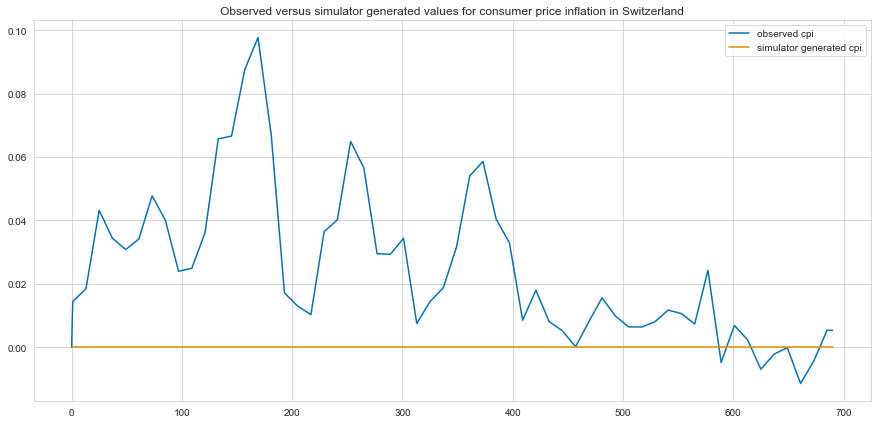

In [222]:
plt.figure(figsize=(15,7))
plt.plot(cpi, label='observed cpi')
plt.plot(generated_cpi, label='simulator generated cpi')
plt.legend()
plt.title('Observed versus simulator generated values for consumer price inflation in %s' % country)
plt.show()

In [223]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(cpi, generated_cpi)),
                                                           np.mean(cpi), np.mean(generated_cpi)))

rmse: 0.03412648700641462
mean observed: 0.025158758986210967
mean generated: 1.0852799659903413e-19


In [224]:
generated_hhcons = gen_df[3].values
gan_hhcons = factual_df[['household consumption expenditure']][0:n].values

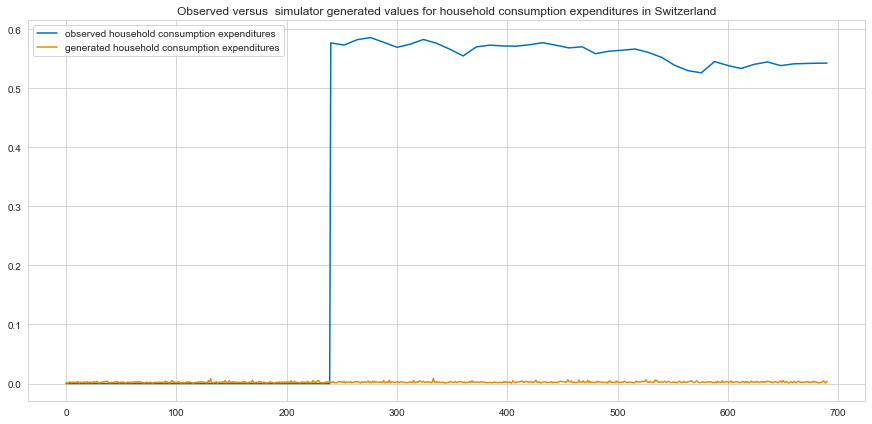

In [225]:
plt.figure(figsize=(15,7))
plt.plot(gan_hhcons, label='observed household consumption expenditures')
plt.plot(generated_hhcons, label='generated household consumption expenditures')
plt.legend()
plt.title('Observed versus  simulator generated values for household consumption expenditures in %s' % country)
plt.show()

## Counterfactual simulation

In this simple simulation, the counterfactual conditional variable is `x` times what is found in the observed data.

In [226]:
cf_df = factual_df
cf_df['trade'] = factual_df['trade'] * 2.

In [227]:
cf_src, cf_tar, cf_src_history, cf_y = timeseries_dataprep(num_obs, num_variables, params['num_timesteps'], cf_df)

In [228]:
sim_preds = simulator.predict([cf_src, cf_src_history, cf_tar])[0]
counterfactual_predictions = map(lambda v: v.flatten(), sim_preds)
cf_sim_df = pd.DataFrame(counterfactual_predictions)
cf_sim_df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000
mean,0.0000,0.0000,0.0000,0.0027,0.0003,0.0004,0.0000,0.0001,0.0000,0.0000,0.0000
std,0.0000,0.0000,0.0000,0.0013,0.0001,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000
min,0.0000,0.0000,0.0000,0.0006,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0018,0.0002,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0024,0.0003,0.0003,0.0000,0.0001,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0034,0.0004,0.0004,0.0000,0.0002,0.0000,0.0000,0.0000
max,0.0000,0.0000,0.0000,0.0099,0.0010,0.0011,0.0001,0.0006,0.0000,0.0000,0.0000


In [229]:
cf_cpi = cf_sim_df[num_variables-1].values
cpi = sim_df[['label']][0:n].values

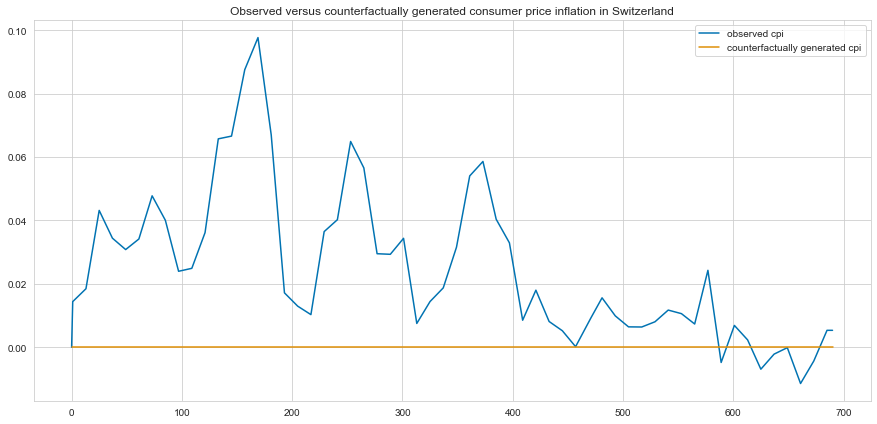

In [230]:
plt.figure(figsize=(15,7))
plt.plot(cpi, label='observed cpi')
plt.plot(cf_cpi, label='counterfactually generated cpi')
plt.legend()
plt.title('Observed versus counterfactually generated consumer price inflation in %s' % country)
plt.show()

In [231]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(cpi, cf_cpi)),
                                                           np.mean(cpi), np.mean(cf_cpi)))

rmse: 0.03412648700641462
mean observed: 0.025158758986210967
mean generated: 1.0754457829231781e-19
